[*********************100%%**********************]  1 of 1 completed


Training Set Metrics
Sharpe Ratio: 0.2218730518333267
Total Return: 10.72%
Annualized Return: 1.84%
Number of Trades: 25.0

Testing Set Metrics
Sharpe Ratio: 0.5149247957261802
Total Return: 8.75%
Annualized Return: 6.19%
Number of Trades: 5.0

Initial Portfolio Value for Testing Set: 100000.0

First 5 days of the testing set:
             Returns  Signal  Position  Strategy      Portfolio
Date                                                           
2022-08-08 -0.001238       1       0.0 -0.000000  100000.000000
2022-08-09 -0.004249       1       1.0 -0.034249   96575.130711
2022-08-10  0.021291       1       1.0  0.021291   98631.276824
2022-08-11 -0.000705       1       1.0 -0.000705   98561.695026
2022-08-12  0.017322       1       1.0  0.017322  100269.017055


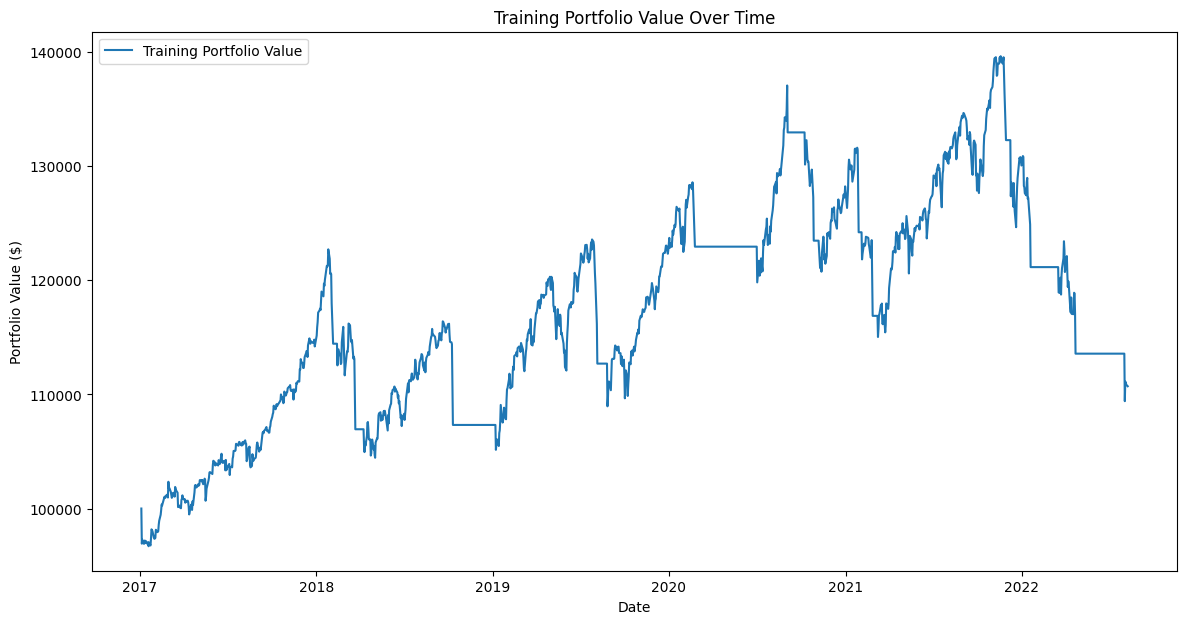

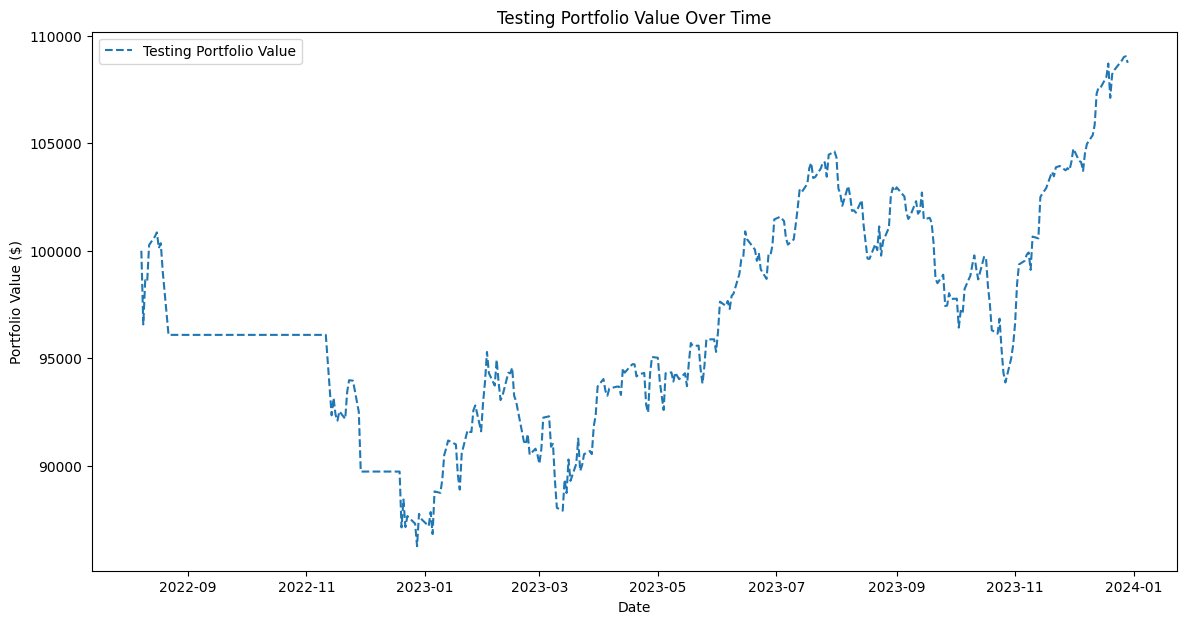

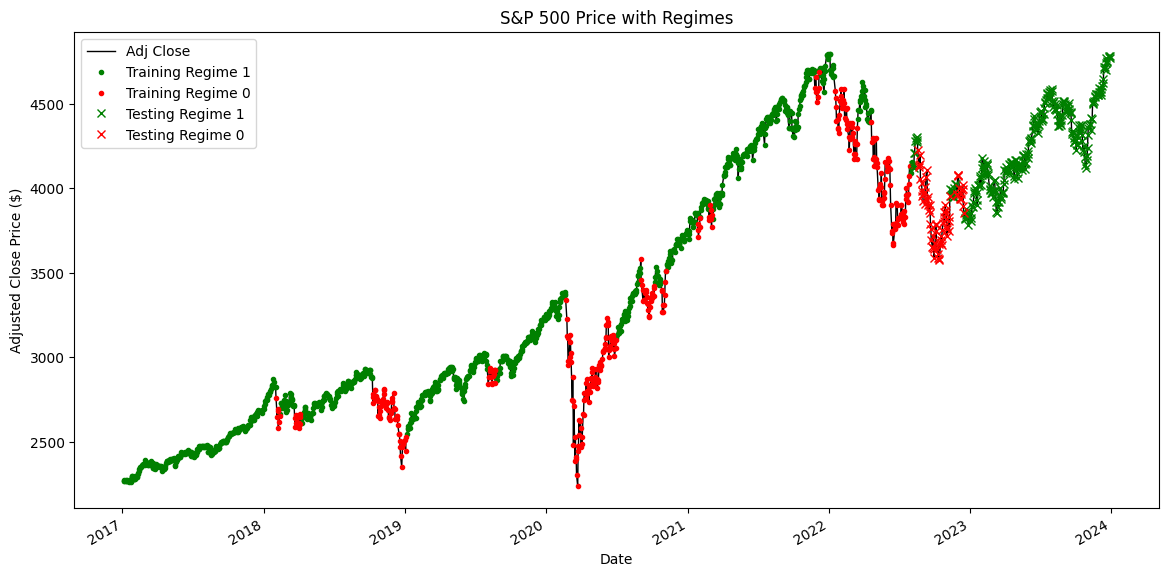

In [48]:
import pandas as pd
import numpy as np
import yfinance as yf
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load data
ticker = "^GSPC"
start_date = "2017-01-01"
end_date = "2023-12-31"

data = yf.download(ticker, start=start_date, end=end_date)
data = data[['Adj Close']].copy()
data['Returns'] = data['Adj Close'].pct_change()
data = data.dropna()

# Split data into training and testing sets (80% training, 20% testing)
split_date = data.index[int(0.8 * len(data))]
train_data = data[:split_date].copy()
test_data = data[split_date:].copy()

# Prepare data for HMM
train_returns = train_data['Returns'].values.reshape(-1, 1)
test_returns = test_data['Returns'].values.reshape(-1, 1)

# Train HMM
hmm_model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000)
hmm_model.fit(train_returns)

# Predict regimes on training and testing sets
train_hidden_states = hmm_model.predict(train_returns)
test_hidden_states = hmm_model.predict(test_returns)

# Add hidden states to the dataframes
train_data.loc[:, 'Regime'] = train_hidden_states
test_data.loc[:, 'Regime'] = test_hidden_states

# Identify the "good" regime based on average returns
train_data['Regime_Returns'] = train_data.groupby('Regime')['Returns'].transform('mean')
good_regime = train_data.groupby('Regime')['Regime_Returns'].mean().idxmax()

# Generate trading signals based on the identified "good" regime
train_data.loc[:, 'Signal'] = np.where(train_data['Regime'] == good_regime, 1, 0)
test_data.loc[:, 'Signal'] = np.where(test_data['Regime'] == good_regime, 1, 0)

# Backtest the strategy
initial_capital = 100000
trading_cost = 0.03

def backtest(data, initial_capital):
    data.loc[:, 'Position'] = data['Signal'].shift(1)
    data.loc[:, 'Position'] = data['Position'].fillna(0)
    data.loc[:, 'Strategy'] = data['Position'] * data['Returns']
    data.loc[:, 'Strategy'] = data['Strategy'] - trading_cost * np.abs(data['Position'].diff()).fillna(0)
    data.loc[:, 'Portfolio'] = initial_capital * (1 + data['Strategy']).cumprod()
    return data

train_data = backtest(train_data, initial_capital)
test_data = backtest(test_data, initial_capital)

# Calculate performance metrics
def calculate_metrics(data):
    sharpe_ratio = data['Strategy'].mean() / data['Strategy'].std() * np.sqrt(252)
    total_return = data['Portfolio'].iloc[-1] / initial_capital - 1
    annualized_return = (1 + total_return) ** (1 / (len(data) / 252)) - 1
    number_of_trades = data['Position'].diff().abs().sum()
    return sharpe_ratio, total_return, annualized_return, number_of_trades

train_metrics = calculate_metrics(train_data)
test_metrics = calculate_metrics(test_data)

print("Training Set Metrics")
print(f"Sharpe Ratio: {train_metrics[0]}")
print(f"Total Return: {train_metrics[1] * 100:.2f}%")
print(f"Annualized Return: {train_metrics[2] * 100:.2f}%")
print(f"Number of Trades: {train_metrics[3]}")

print("\nTesting Set Metrics")
print(f"Sharpe Ratio: {test_metrics[0]}")
print(f"Total Return: {test_metrics[1] * 100:.2f}%")
print(f"Annualized Return: {test_metrics[2] * 100:.2f}%")
print(f"Number of Trades: {test_metrics[3]}")

# Print initial portfolio value for testing set
print("\nInitial Portfolio Value for Testing Set:", test_data['Portfolio'].iloc[0])

# Debugging: Print the first 5 days of the testing set
print("\nFirst 5 days of the testing set:")
print(test_data[['Returns', 'Signal', 'Position', 'Strategy', 'Portfolio']].head(5))

# Plot portfolio value for training set
plt.figure(figsize=(14, 7))
plt.plot(train_data['Portfolio'], label='Training Portfolio Value')
plt.title('Training Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

# Plot portfolio value for testing set
plt.figure(figsize=(14, 7))
plt.plot(test_data['Portfolio'], label='Testing Portfolio Value', linestyle='--')
plt.title('Testing Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

# Plot stock price with regimes for training and testing sets
fig, ax = plt.subplots(figsize=(14, 7))
data['Adj Close'].plot(ax=ax, color='black', lw=1)
regime_colors = {0: 'red', 1: 'green'}

for regime in train_data['Regime'].unique():
    mask = train_data['Regime'] == regime
    ax.plot(train_data.index[mask], train_data['Adj Close'][mask], linestyle='None', marker='.', color=regime_colors[regime], label=f'Training Regime {regime}')

for regime in test_data['Regime'].unique():
    mask = test_data['Regime'] == regime
    ax.plot(test_data.index[mask], test_data['Adj Close'][mask], linestyle='None', marker='x', color=regime_colors[regime], label=f'Testing Regime {regime}')

ax.set_title('S&P 500 Price with Regimes')
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close Price ($)')
ax.legend()
plt.show()
